# Creating Pokedex with Keras, using CNNs

First we need to create our architecture for training our Pokedex model.
We'll use a VGGNet-like architecture  introduced by Simonyan and Zisserman in their 2014 paper, __Very Deep Convolutional Networks for Large Scale Image Recognition__.

VGGNet-like architectures are characterized by:

1. Using only 3×3 convolutional layers stacked on top of each other in increasing depth
2. Reducing volume size by max pooling
3. Fully-connected layers at the end of the network prior to a softmax classifier

So, let's implement SmallerVGGNet

## SmallerVGGNet

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# check Tf version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use newer version of TensorFlow'
print('TensorFlow version: {}'.format(tf.__version__))

print('Default GPU Device : {}'.format(tf.test.gpu_device_name()))

TensorFlow version: 1.13.1
Default GPU Device : /device:GPU:0


In [2]:
#import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


Now, we can go on to define the architecture.

Our build method requires four parameters:

- `width` : The image width dimension.
- `height` : The image height dimension.
- `depth` : The depth of the image — also known as the number of channels.
- `classes` : The number of classes in our dataset (which will affect the last layer of our model). We’re utilizing 5 Pokemon classes 

___Note: We’ll be working with input images that are  96 x 96 with a depth of 3  (as we’ll see later in this post). Keep this in mind as we explain the spatial dimensions of the input volume as it passes through the network.__

Since we’re using the TensorFlow backend, we arrange the input shape with “channels last” data ordering, but if you want to use “channels first” (Theano, etc.) then it is handled automagically.

Now, let’s start adding layers to our model:

In [3]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # 'channels last' and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # lets add some layers
        # CONV => RELU => POOL
        model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", 
                          input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(rate=0.25))
        
        
        # From there we’ll add  (CONV => RELU) * 2  layers before
        # applying another POOL  layer
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        
        # Let’s add another set of   (CONV => RELU) * 2 => POOL
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.25))
        
        # finally, we have a set of FC => RELU  layers and a 
        # softmax classifier:
        model.add(Flatten())
        model.add(Dense(units=1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

Now that our model architecture is defined we can move on to the training script.

## Implementing CNN & Keras Training Script

In [5]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

%matplotlib inline

The `ImageDataGenerator`  class will be used for data augmentation, a technique used to take existing images in our dataset and apply random transformations (rotations, shearing, etc.) to generate additional training data. Data augmentation helps prevent overfitting.


The `LabelBinarizer` is an important class to note — this class will enable us to:

1. Input a set of class labels (i.e., strings representing the human-readable class labels in our dataset).
2. Transform our class labels into one-hot encoded vectors.
3. Allow us to take an integer class label prediction from our Keras CNN and transform it back into a human-readable label.


_Our dataset is organized in a dataset  directory with subdirectories representing each class. Inside each subdirectory is ~250 Pokemon images. See the project directory structure at the top of this post for more details._

In [6]:
# initialize the number of epochs to trian for, inintial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)


# path to dataset directory
path_dataset = "dataset"


# initialize the data and labels
data = []
labels = []

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(path_dataset)))
random.seed(42)
random.shuffle(imagePaths)


[INFO] loading images...


In [7]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, preprocess it, and store it in data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    # extract the class labels from the image path and update the 
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
    

Consider that fact that we purposely created our dataset directory structure to have the following format:
`dataset/{CLASS_LABEL}/{FILENAME}.jpg`

Using the path separator we can split the path into an array and then grab the second-to-last entry in the list — the class label.
        

In [8]:
labels[:5]

['squirtle', 'pikachu', 'mewtwo', 'pikachu', 'mewtwo']

In [9]:
# scale the raw pixel intensities to range [0, 1]
data = np.array(data, dtype="float")/255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes/(1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the dataset into training and test splits using 80% of 
# data for training and the remaining 20% for cross-validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.2, random_state=42)


[INFO] data matrix: 252.07MB


Next, we need to create image data augmentation object

In [10]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

Since we’re working with a limited amount of data points (< 250 images per class), we can make use of data augmentation during the training process to give our model more images (based on existing images) to train with.

Let’s compile the model and kick off the training:

In [11]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
                           depth=IMAGE_DIMS[2], classes=len(lb.classes_))

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
             metrics=["accuracy"])


[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# train the network 
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX,testY), 
    steps_per_epoch=len(trainX)//BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
29/29 [==============================] - 14s 473ms/step - loss: 1.4171 - acc: 0.6131 - val_loss: 1.8084 - val_acc: 0.7137
Epoch 2/100
29/29 [==============================] - 7s 256ms/step - loss: 0.7593 - acc: 0.7538 - val_loss: 1.1616 - val_acc: 0.7906
Epoch 3/100
29/29 [==============================] - 7s 238ms/step - loss: 0.7434 - acc: 0.7827 - val_loss: 0.8726 - val_acc: 0.7821
Epoch 4/100
29/29 [==============================] - 7s 240ms/step - loss: 0.7028 - acc: 0.7695 - val_loss: 1.3202 - val_acc: 0.7564
Epoch 5/100
29/29 [==============================] - 7s 257ms/step - loss: 0.5915 - acc: 0.8030 - val_loss: 1.1131 - val_acc: 0.8034
Epoch 6/100
29/29 [==============================] - 7s 239ms/step - loss: 0.5942 - acc: 0.8118 - val_loss: 0.8237 - val_acc: 0.8376
Epoch 7/100
29/29 [==============================] - 7s 236ms/step - loss: 0.5327 - acc: 0.8414 - val_loss: 0.7178 - val_acc: 

In [13]:
# save the model to disk
print("[INFO]  serializing network...")
model.save("pokedex.model")

[INFO]  serializing network...


In [14]:
# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing label binarizer...


Finally, we can plot our our training loss and accuracy

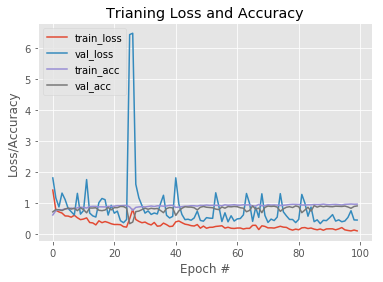

In [15]:
plt.style.use("ggplot")
plt.figure()
N =  EPOCHS
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_acc"], label="val_acc")
plt.title("Trianing Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("plot.png")
plt.show()

## Classifying Images with our trained model

In [16]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [18]:
path_model = "pokedex.model"
path_label_binarizer = "lb.pickle"
path_test_images = "examples" 

In [19]:
# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading model...")
model = load_model(path_model)
lb = pickle.loads(open(path_label_binarizer, "rb").read())

[INFO] loading model...


In [20]:
for img_path in imutils.paths.list_images(path_test_images):
    filename = img_path[img_path.rfind(os.path.sep) +1:]
    print(filename)
    


bulbasaur_plush.png
charmander_counter.png
charmander_hidden.png
mewtwo_toy.png
pikachu_toy.png
squirtle_plush.png


[INFO] Classifying image...
bulbasaur
[INFO] Classifying image...
charmander
[INFO] Classifying image...
charmander
[INFO] Classifying image...
mewtwo
[INFO] Classifying image...
pikachu
[INFO] Classifying image...
squirtle


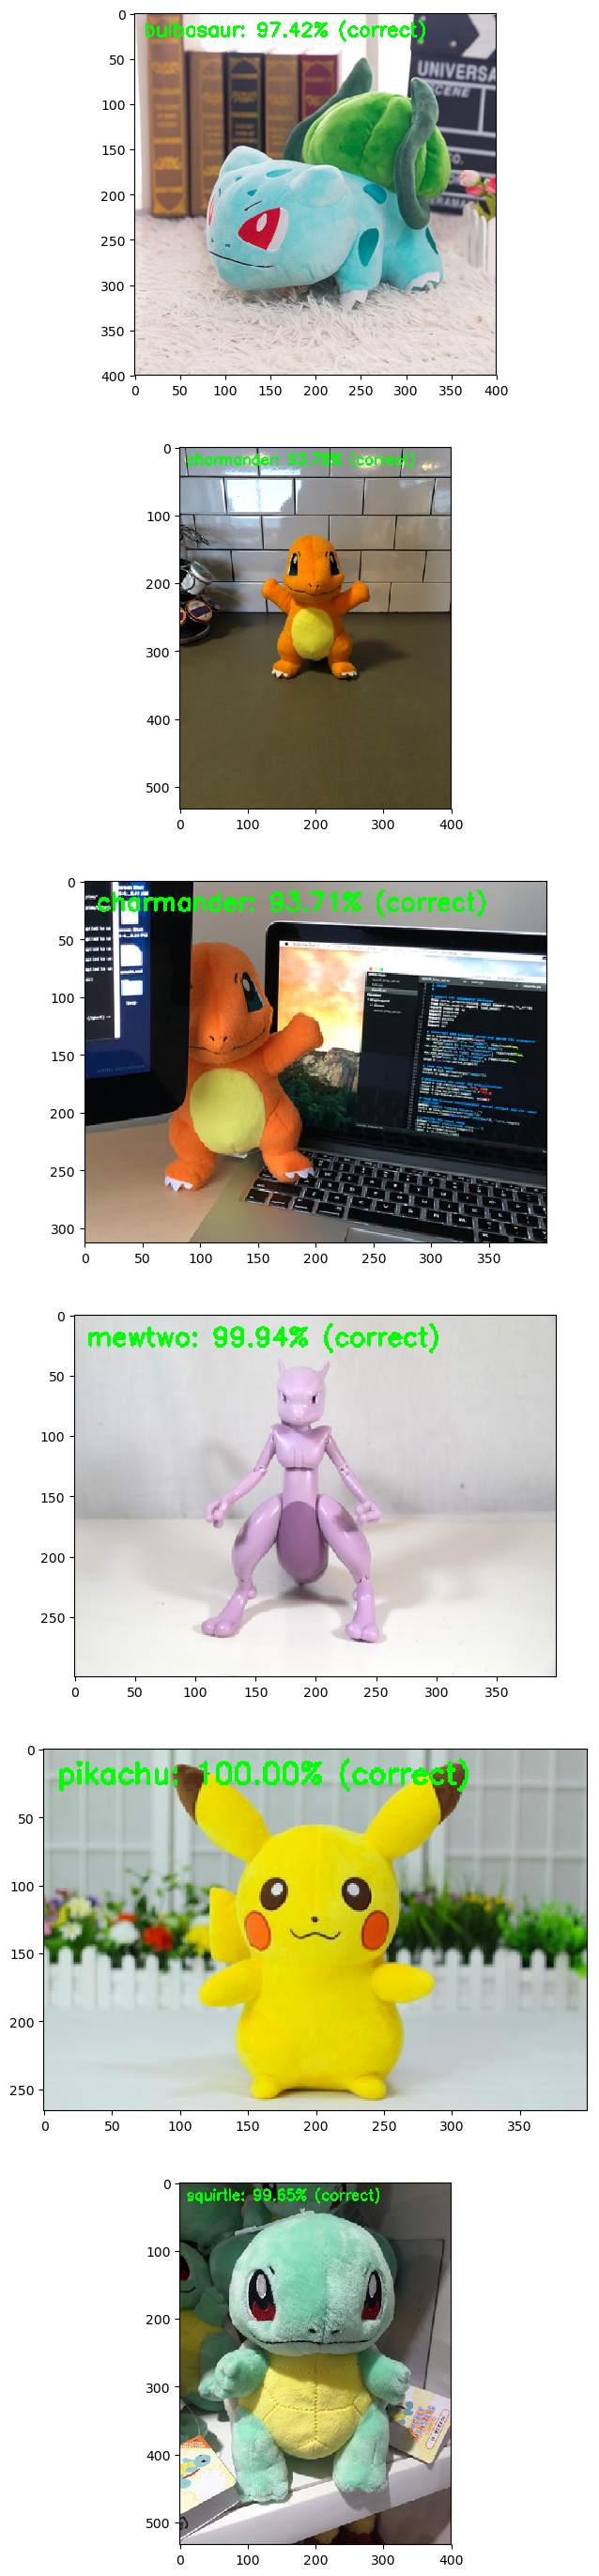

In [21]:
plt.style.use('default')
fig, ax = plt.subplots(6, 1, figsize=(35,35)) # 6 rows beacse 6 images in directory
# load the images from directory
# loop over them and classifiy each of them
counter = 0
for img_path in imutils.paths.list_images(path_test_images):
    # load the image
    image = cv2.imread(img_path)
    output = image.copy()
    
    # pre-process the image, make it ready of network
    image = cv2.resize(image, (96,96))
    image = image.astype("float")/255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # classify image
    print("[INFO] Classifying image...")
    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    print(label)
    
    # we'll mark our prediction as "correct" if the input image filename
    # contains the predicted label text (assumption that you have named your 
    # testing image files this way)
    filename = img_path[img_path.rfind(os.path.sep) +1:]
    correct = "correct" if filename.rfind(label) != -1 else "incorrect"
    
    # build label and draw the label on the image
    label = "{}: {:.2f}% ({})".format(label, proba[idx]*100, correct)
    output = imutils.resize(output, width=400)
    cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
               (0.7), (0, 255, 0), 2)
    
    # plot the image
    ax[counter].imshow(output[...,::-1])
    
    counter+=1

plt.show()